# Optimizing a Trading Strategy Using Optuna: A Case Study on APPL
### Axel Santiago Molina Ceja & Pablo Lemus

## **Introduction**  
In this project, we developed and optimized a quantitative trading strategy using *Optuna*, a powerful hyperparameter optimization framework. The strategy was tested on historical stock data for **Apple Inc. (APPL)**, and we implemented a backtesting framework to evaluate its performance.  

The optimization process focused not only on tuning entry and exit conditions but also on dynamically adjusting the **number of shares traded per position** (*n_shares*). By leveraging *Optuna*, we systematically identified the best combination of trading parameters to maximize overall portfolio performance. Finally, we visualized the strategy’s historical performance through graphical analysis.  

---

## **Trading Strategy and Technical Indicators**  
Our trading strategy is based on a combination of three widely used technical indicators:  

1. **Relative Strength Index (RSI)**  
   - Measures momentum and overbought/oversold conditions.  
   - We optimized the **RSI window** size and the **upper/lower bounds** to determine optimal trade signals.  
   - **Buy Signal:** When RSI falls below a threshold (e.g., 30), indicating oversold conditions.  
   - **Sell Signal:** When RSI rises above a threshold (e.g., 70), indicating overbought conditions.  

2. **Bollinger Bands (BB)**  
   - Measures price volatility and mean reversion tendencies.  
   - The strategy buys when the price is below the lower band and sells when above the upper band.  
   - We optimized the **BB window** (period) and **standard deviation multiplier** to fine-tune the bands.  

3. **Moving Average Convergence Divergence (MACD)**  
   - Identifies trend direction and momentum shifts.  
   - Uses two EMAs (Exponential Moving Averages): a **short-term** and a **long-term** moving average.  
   - The strategy goes **long** when the MACD crosses above the signal line and **short** when it crosses below.  

Additionally, we implemented **stop-loss** and **take-profit** mechanisms to manage risk and optimize trade exits.  

---

## **Performance Metrics**  
To evaluate the effectiveness of our strategy, we computed several key performance metrics:  

1. **Sharpe Ratio**  
   - Measures risk-adjusted returns.  
   - Higher values indicate better returns per unit of risk.  

2. **Sortino Ratio**  
   - Similar to the Sharpe Ratio but focuses only on downside risk.  
   - More relevant for investors who prioritize avoiding large losses.  

3. **Calmar Ratio**  
   - Evaluates return relative to the **maximum drawdown** (largest peak-to-trough drop).  
   - Higher values suggest a more stable and consistent strategy.  

4. **Win/Loss Ratio**  
   - Compares the number of winning trades to losing trades.  
   - Useful for understanding the probability of successful trades.  


In [1]:
import numpy as np
import ta
import pandas as pd 
import matplotlib.pyplot as plt
import optuna

In [2]:
data = pd.read_csv("/Users/axelmolina/Desktop/Noveno Semestre/Trading/Proyecto3/aapl_5m_train.csv").dropna()

In [3]:
import numpy as np
import ta
import optuna

def objective(trial, data):
    data = data.copy()
    
    # Hiperparámetros de la estrategia
    rsi_window = trial.suggest_int("rsi_window", 10, 100)
    rsi_upper = trial.suggest_int("rsi_upper", 70, 95)
    rsi_lower = trial.suggest_int("rsi_lower", 5, 30)
    
    stop_loss = trial.suggest_float("stop_loss", 0.04, 0.12)
    take_profit = trial.suggest_float("take_profit", 0.04, 0.12)
    
    bb_window = trial.suggest_int("bb_window", 10, 100)
    bb_std = trial.suggest_int("bb_std", 1, 3)
    
    macd_short = trial.suggest_int("macd_short", 10, 50)
    macd_long = trial.suggest_int("macd_long", 50, 200)
    macd_signal = trial.suggest_int("macd_signal", 5, 20)

    # Optimización de número de acciones a operar
    n_shares = trial.suggest_int("n_shares", 2000, 5000, step=1000)

    # Cálculo de indicadores
    rsi = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data["RSI"] = rsi.rsi()
    
    bb = ta.volatility.BollingerBands(data.Close, window=bb_window, window_dev=bb_std)
    data["BB"] = bb.bollinger_mavg()
    data["BB_BUY"] = bb.bollinger_lband_indicator().astype(bool)
    data["BB_SELL"] = bb.bollinger_hband_indicator().astype(bool)
    
    macd = ta.trend.MACD(data.Close, window_slow=macd_long, window_fast=macd_short, window_sign=macd_signal)
    data["MACD"] = macd.macd()
    data["MACD_SIGNAL"] = macd.macd_signal()
    
    dataset = data.dropna()
    
    # Parámetros de simulación
    capital = 1_000_000
    com = 0.125 / 100
    portfolio_value = [capital]
    active_long = None
    active_short = None
    win = 0
    loss = 0
    
    for i, row in dataset.iterrows():
        # Cerrar posiciones largas
        if active_long:
            if row.Close >= active_long["take_profit"] or row.Close <= active_long["stop_loss"]:
                pnl = row.Close * active_long["n_shares"] * (1 - com)
                capital += pnl
                win += 1 if row.Close >= active_long["take_profit"] else 0
                loss += 1 if row.Close <= active_long["stop_loss"] else 0
                active_long = None
        
        # Cerrar posiciones cortas
        if active_short:
            if row.Close <= active_short["take_profit"] or row.Close >= active_short["stop_loss"]:
                pnl = (active_short["opened_at"] - row.Close) * active_short["n_shares"] * (1 - com)
                capital += pnl
                win += 1 if row.Close <= active_short["take_profit"] else 0
                loss += 1 if row.Close >= active_short["stop_loss"] else 0
                active_short = None
        
        # Abrir posición larga
        if sum([row.RSI < rsi_lower, row.BB_BUY, row.MACD > row.MACD_SIGNAL]) >= 2 and not active_long:
            cost = row.Close * n_shares * (1 + com)
            if capital >= cost:
                capital -= cost
                active_long = {
                    "opened_at": row.Close, 
                    "take_profit": row.Close * (1 + take_profit), 
                    "stop_loss": row.Close * (1 - stop_loss), 
                    "n_shares": n_shares
                }
        
        # Abrir posición corta
        if sum([row.RSI > rsi_upper, row.BB_SELL, row.MACD < row.MACD_SIGNAL]) >= 2 and not active_short:
            cost = row.Close * n_shares * com
            if capital >= cost:
                capital -= cost
                active_short = {
                    "opened_at": row.Close, 
                    "take_profit": row.Close * (1 - take_profit), 
                    "stop_loss": row.Close * (1 + stop_loss), 
                    "n_shares": n_shares
                }
        
        # Actualizar valor del portafolio
        long_val = active_long["opened_at"] * active_long["n_shares"] if active_long else 0
        short_val = (active_short["opened_at"] - row.Close) * active_short["n_shares"] if active_short else 0
        portfolio_value.append(capital + long_val + short_val)
    
    # Cálculo de métricas de rendimiento
    rets = pd.Series(portfolio_value).pct_change().dropna()
    er = rets.mean()
    ev= rets.std()
    dt = (252)*(6.5)*(60/5)
    sharpe_ratio = (er*dt)/(ev*np.sqrt(dt))
    returns = np.diff(portfolio_value) / portfolio_value[:-1] # actual menos el anterior, entre el anterior
    downside_returns = returns[returns < 0]  
    downside_std = np.std(downside_returns)
    sortino_ratio = (np.mean(returns) * dt) / (downside_std * np.sqrt(dt)) if downside_std != 0 else 0
    calmar_ratio = (np.mean(returns) * dt) / abs(min(returns)) if min(returns) != 0 else 0
    win_loss_ratio = win / (win + loss) if (win + loss) != 0 else 0
    
    return sharpe_ratio if not np.isnan(sharpe_ratio) else -np.inf

In [4]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda x: objective(x, data), n_trials=50)

[I 2025-03-26 13:04:48,722] A new study created in memory with name: no-name-4af8c82f-9dab-4316-a38e-4347b17e5a7f
[I 2025-03-26 13:04:50,002] Trial 0 finished with value: 0.027490903195104433 and parameters: {'rsi_window': 20, 'rsi_upper': 83, 'rsi_lower': 30, 'stop_loss': 0.09584330910005248, 'take_profit': 0.09056798812362109, 'bb_window': 18, 'bb_std': 1, 'macd_short': 49, 'macd_long': 142, 'macd_signal': 9, 'n_shares': 2000}. Best is trial 0 with value: 0.027490903195104433.
[I 2025-03-26 13:04:51,031] Trial 1 finished with value: 0.4781595219003972 and parameters: {'rsi_window': 46, 'rsi_upper': 91, 'rsi_lower': 29, 'stop_loss': 0.07964787985672661, 'take_profit': 0.05774351855786687, 'bb_window': 75, 'bb_std': 2, 'macd_short': 30, 'macd_long': 165, 'macd_signal': 7, 'n_shares': 5000}. Best is trial 1 with value: 0.4781595219003972.
[I 2025-03-26 13:04:52,115] Trial 2 finished with value: 0.19397213982390324 and parameters: {'rsi_window': 20, 'rsi_upper': 83, 'rsi_lower': 9, 'stop

In [5]:
study.best_trial

FrozenTrial(number=44, state=1, values=[1.7918948650629354], datetime_start=datetime.datetime(2025, 3, 26, 13, 5, 34, 385166), datetime_complete=datetime.datetime(2025, 3, 26, 13, 5, 35, 346799), params={'rsi_window': 38, 'rsi_upper': 84, 'rsi_lower': 23, 'stop_loss': 0.0668297551604275, 'take_profit': 0.09950039317429801, 'bb_window': 83, 'bb_std': 3, 'macd_short': 41, 'macd_long': 82, 'macd_signal': 9, 'n_shares': 3000}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rsi_window': IntDistribution(high=100, log=False, low=10, step=1), 'rsi_upper': IntDistribution(high=95, log=False, low=70, step=1), 'rsi_lower': IntDistribution(high=30, log=False, low=5, step=1), 'stop_loss': FloatDistribution(high=0.12, log=False, low=0.04, step=None), 'take_profit': FloatDistribution(high=0.12, log=False, low=0.04, step=None), 'bb_window': IntDistribution(high=100, log=False, low=10, step=1), 'bb_std': IntDistribution(high=3, log=False, low=1, step=1), 'macd_short': IntDistri

In [6]:
study.best_value

1.7918948650629354

In [7]:
study.best_params

{'rsi_window': 38,
 'rsi_upper': 84,
 'rsi_lower': 23,
 'stop_loss': 0.0668297551604275,
 'take_profit': 0.09950039317429801,
 'bb_window': 83,
 'bb_std': 3,
 'macd_short': 41,
 'macd_long': 82,
 'macd_signal': 9,
 'n_shares': 3000}

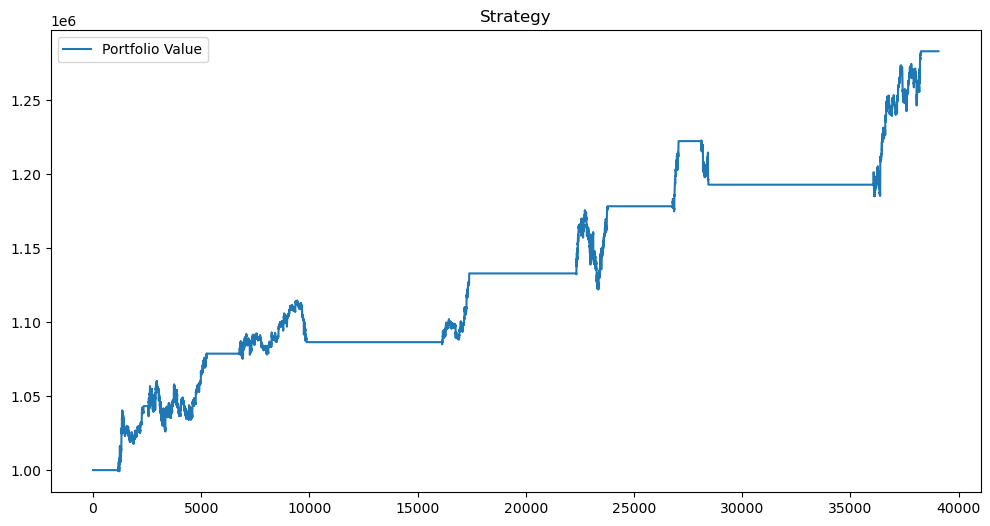

Final Portfolio Value: 1,283,198.13
Sharpe Ratio: 2.0821
Sortino Ratio: 1.5636
Calmar Ratio: 11.6012
Win/Loss Ratio: 0.8000


2.0821435638695682

In [8]:
def run_strategy(data, params):
    data = data.copy()
    
    rsi_window = params["rsi_window"]
    rsi_upper = params["rsi_upper"]
    rsi_lower = params["rsi_lower"]
    stop_loss = params["stop_loss"]
    take_profit = params["take_profit"]
    bb_window = params["bb_window"]
    bb_std = params["bb_std"]
    macd_short = params["macd_short"]
    macd_long = params["macd_long"]
    macd_signal = params["macd_signal"]
    n_shares = params["n_shares"]
    
    # RSI
    rsi = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data["RSI"] = rsi.rsi()
    
    # Bollinger Bands
    bb = ta.volatility.BollingerBands(data.Close, window=bb_window, window_dev=bb_std)
    data["BB"] = bb.bollinger_mavg()
    data["BB_BUY"] = bb.bollinger_lband_indicator().astype(bool)
    data["BB_SELL"] = bb.bollinger_hband_indicator().astype(bool)
    
    # MACD
    macd = ta.trend.MACD(data.Close, window_slow=macd_long, window_fast=macd_short, window_sign=macd_signal)
    data["MACD"] = macd.macd()
    data["MACD_SIGNAL"] = macd.macd_signal()
    
    dataset = data.dropna()
    
    capital = 1_000_000
    com = 0.125/100
    portfolio_value = [capital]
    active_long = None
    active_short = None
    win = 0
    loss = 0
    
    for i, row in dataset.iterrows():
        # Close long positions
        if active_long:
            if row.Close >= active_long["take_profit"] or row.Close <= active_long["stop_loss"]:
                pnl = row.Close * n_shares * (1-com)
                capital += pnl
                win += 1 if row.Close >= active_long["take_profit"] else 0
                loss += 1 if row.Close <= active_long["stop_loss"] else 0
                active_long = None
        
        # Close short positions
        if active_short:
            if row.Close <= active_short["take_profit"] or row.Close >= active_short["stop_loss"]:
                pnl = (active_short["opened_at"] - row.Close) * n_shares * (1-com)
                capital += pnl
                win += 1 if row.Close <= active_short["take_profit"] else 0
                loss += 1 if row.Close >= active_short["stop_loss"] else 0
                active_short = None
        
        # Open long position
        if sum([row.RSI < rsi_lower, row.BB_BUY, row.MACD > row.MACD_SIGNAL]) >= 2 and not active_long:
            cost = row.Close * n_shares * (1+com)
            if capital >= cost:
                capital -= cost
                active_long = {"opened_at": row.Close, "take_profit": row.Close * (1+take_profit), "stop_loss": row.Close * (1-stop_loss)}
        
        # Open short position
        if sum([row.RSI > rsi_upper, row.BB_SELL, row.MACD < row.MACD_SIGNAL]) >= 2 and not active_short:
            cost = row.Close * n_shares * com
            if capital >= cost:
                capital -= cost
                active_short = {"opened_at": row.Close, "take_profit": row.Close * (1-take_profit), "stop_loss": row.Close * (1+stop_loss)}
        
        # Update portfolio value
        long_val = row.Close * n_shares if active_long else 0
        short_val = (active_short["opened_at"] - row.Close) * n_shares if active_short else 0
        portfolio_value.append(capital + long_val + short_val)



     # Cálculo de métricas de rendimiento
    rets = pd.Series(portfolio_value).pct_change().dropna()
    er = rets.mean()
    ev= rets.std()
    dt = (252)*(6.5)*(60/5)
    sharpe_ratio = (er*dt)/(ev*np.sqrt(dt))
    returns = np.diff(portfolio_value) / portfolio_value[:-1] # actual menos el anterior, entre el anterior
    downside_returns = returns[returns < 0]  
    downside_std = np.std(downside_returns)
    sortino_ratio = (np.mean(returns) * dt) / (downside_std * np.sqrt(dt)) if downside_std != 0 else 0
    calmar_ratio = (np.mean(returns) * dt) / abs(min(returns)) if min(returns) != 0 else 0
    win_loss_ratio = win / (win + loss) if (win + loss) != 0 else 0
    
    # Plot portfolio value
    plt.figure(figsize=(12,6))
    plt.title("Strategy")
    plt.plot(portfolio_value, label="Portfolio Value")
    plt.legend()
    plt.show()
    
    print(f"Final Portfolio Value: {portfolio_value[-1]:,.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Sortino Ratio: {sortino_ratio:.4f}")
    print(f"Calmar Ratio: {calmar_ratio:.4f}")
    print(f"Win/Loss Ratio: {win_loss_ratio:.4f}")
    
    return sharpe_ratio if not np.isnan(sharpe_ratio) else -np.inf

# Run strategy with best parameters
best_params = study.best_params  # Assuming study is already optimized
run_strategy(data, best_params)

# Copiate esto en en Best_params()

In [ ]:
import numpy as np
import ta
import pandas as pd
import matplotlib.pyplot as plt
import pickle

def run_strategy(data, params):
    data = data.copy()

    rsi_window = params["rsi_window"]
    rsi_upper = params["rsi_upper"]
    rsi_lower = params["rsi_lower"]
    stop_loss = params["stop_loss"]
    take_profit = params["take_profit"]
    bb_window = params["bb_window"]
    bb_std = params["bb_std"]
    macd_short = params["macd_short"]
    macd_long = params["macd_long"]
    macd_signal = params["macd_signal"]
    n_shares = params["n_shares"]

    # RSI
    rsi = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data["RSI"] = rsi.rsi()

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(data.Close, window=bb_window, window_dev=bb_std)
    data["BB"] = bb.bollinger_mavg()
    data["BB_BUY"] = bb.bollinger_lband_indicator().astype(bool)
    data["BB_SELL"] = bb.bollinger_hband_indicator().astype(bool)

    # MACD
    macd = ta.trend.MACD(data.Close, window_slow=macd_long, window_fast=macd_short, window_sign=macd_signal)
    data["MACD"] = macd.macd()
    data["MACD_SIGNAL"] = macd.macd_signal()

    dataset = data.dropna()

    capital = 1_000_000
    com = 0.125 / 100
    portfolio_value = [capital]
    active_long = None
    active_short = None
    win = 0
    loss = 0

    for i, row in dataset.iterrows():
        # Close long positions
        if active_long:
            if row.Close >= active_long["take_profit"] or row.Close <= active_long["stop_loss"]:
                pnl = row.Close * n_shares * (1 - com)
                capital += pnl
                win += 1 if row.Close >= active_long["take_profit"] else 0
                loss += 1 if row.Close <= active_long["stop_loss"] else 0
                active_long = None

        # Close short positions
        if active_short:
            if row.Close <= active_short["take_profit"] or row.Close >= active_short["stop_loss"]:
                pnl = (active_short["opened_at"] - row.Close) * n_shares * (1 - com)
                capital += pnl
                win += 1 if row.Close <= active_short["take_profit"] else 0
                loss += 1 if row.Close >= active_short["stop_loss"] else 0
                active_short = None

        # Open long position
        if sum([row.RSI < rsi_lower, row.BB_BUY, row.MACD > row.MACD_SIGNAL]) >= 2 and not active_long:
            cost = row.Close * n_shares * (1 + com)
            if capital >= cost:
                capital -= cost
                active_long = {"opened_at": row.Close, "take_profit": row.Close * (1 + take_profit),
                               "stop_loss": row.Close * (1 - stop_loss)}

        # Open short position
        if sum([row.RSI > rsi_upper, row.BB_SELL, row.MACD < row.MACD_SIGNAL]) >= 2 and not active_short:
            cost = row.Close * n_shares * com
            if capital >= cost:
                capital -= cost
                active_short = {"opened_at": row.Close, "take_profit": row.Close * (1 - take_profit),
                                "stop_loss": row.Close * (1 + stop_loss)}

        # Update portfolio value
        long_val = row.Close * n_shares if active_long else 0
        short_val = (active_short["opened_at"] - row.Close) * n_shares if active_short else 0
        portfolio_value.append(capital + long_val + short_val)

    # Cálculo de métricas de rendimiento
    rets = pd.Series(portfolio_value).pct_change().dropna()
    er = rets.mean()
    ev= rets.std()
    dt = (252)*(6.5)*(60/5)
    sharpe_ratio = (er*dt)/(ev*np.sqrt(dt))
    returns = np.diff(portfolio_value) / portfolio_value[:-1] # actual menos el anterior, entre el anterior
    downside_returns = returns[returns < 0]  
    downside_std = np.std(downside_returns)
    sortino_ratio = (np.mean(returns) * dt) / (downside_std * np.sqrt(dt)) if downside_std != 0 else 0
    calmar_ratio = (np.mean(returns) * dt) / abs(min(returns)) if min(returns) != 0 else 0
    win_loss_ratio = win / (win + loss) if (win + loss) != 0 else 0

    # Plot portfolio value
    plt.figure(figsize=(12, 6))
    plt.title("Strategy")
    plt.plot(portfolio_value, label="Portfolio Value")
    plt.legend()
    plt.show()

    print(f"Final Portfolio Value: {portfolio_value[-1]:,.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Sortino Ratio: {sortino_ratio:.4f}")
    print(f"Calmar Ratio: {calmar_ratio:.4f}")
    print(f"Win/Loss Ratio: {win_loss_ratio:.4f}")

    return sharpe_ratio if not np.isnan(sharpe_ratio) else -np.inf

def main():
    print("Running strategy with best parameters...")

    data = pd.read_csv("/Users/axelmolina/Desktop/Noveno Semestre/Trading/Proyecto3/aapl_5m_train.csv").dropna()

    # Cargar parámetros optimizados
    with open("best_params.pkl", "rb") as f:
        best_params = pickle.load(f)

    print("Loaded best parameters:", best_params)

    run_strategy(data, best_params)

if __name__ == "__main__":
    main()

# También agregale esto al if del main.py
Best_params.main()